In [21]:
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error

In [6]:
#environment parameter


oT =700+273.15      #Temperature oxidant (K)
fT =700+273.15      #Temperature fuel (K)

pO2air=0.3          #Air side partial pressure O2 (atm)
pN2air =0.7         #Air side partial pressure N2 (atm)
# pH2 = 0.4375        #Fuel side partial pressure H2 (atm)
# pH2O =0.3125        #Fuel side partial pressure H2O (atm)
# pCO=0.0625          #Fuel side partial pressure CO (atm)
# pCO2=0.0625         #Fuel side partial pressure CO2 (atm)
# pCH4=0.125          #Fuel side partial pressure CH4 (atm)
# pN2=0.0             #Fuel side partial pressure N2 (atm)
pH2 = 0.97        #Fuel side partial pressure H2 (atm)
pH2O =0.03        #Fuel side partial pressure H2O (atm)
pCO=0.0         #Fuel side partial pressure CO (atm)
pCO2=0.0         #Fuel side partial pressure CO2 (atm)
pCH4=0.0          #Fuel side partial pressure CH4 (atm)
pN2=0.0             #Fuel side partial pressure N2 (atm)
pSys=1.0            #System pressure (atm)  

# adjustable parameters for B-V loss (starting with these for optimization)

#J=0.1

IV_Model_2 Natural log function: Original PNNL function

In [7]:
import IV_model

In [8]:
def objective_function_JM(param_guess, param_fixed):  
    
    [pO2air,pN2air,pH2,pH2O,pCO,pCO2,pCH4,pN2,pSys] = param_fixed

    filename = './ExperimentalData/JM2017/AllData_JM.csv'
    data = np.loadtxt(open(filename, "rb"), delimiter=",", skiprows=1)
    x = data[:,0]
    y_exp = data[:,1]
    Toper = data[:, 2]

    y_model = np.zeros(len(y_exp))
    for j in range(len(y_exp)):
        y_model[j], Voc, Ohmic, BV, Cath, Anode = IV_model.IV_new_2(Toper[j]+273.15,Toper[j]+273.15,x[j],
                                                           pO2air,pN2air,pH2,pH2O,pCO,pCO2,pCH4,pN2,pSys,
                                                           param_guess[0], param_guess[1], param_guess[2],
                                                           param_guess[3], param_guess[4], 0.1, 4.51e-5,
                                                             True,param_guess[5],param_guess[6])
    #rmse = mean_squared_error(y_exp, y_model, squared=False)
    rmse = mean_squared_error(y_exp, y_model)
    return rmse

In [14]:
#for IV_new_2
BV_alpha1 = 0.5 #0.43236/3 **
BV_prexp1 = 5639 #**
BV_Eact1 = 79616 #**
#filenameJM = './ExperimentalData/JM2017/AllData_JM.csv'
#IVmodel = 'IV_model.IV_new_2'

     fun: 0.008100040844188704
     jac: array([-1.12986541e-03, -2.21189111e-09,  1.16454903e-05, -3.52901639e-04,
       -1.14956289e-04, -4.18362906e-05, -2.25426629e-06])
 message: 'Optimization terminated successfully.'
    nfev: 110
     nit: 12
    njev: 12
  status: 0
 success: True
       x: array([ 6.31998758e-01,  5.63901224e+03,  1.06918671e+01, -8.66164531e-02,
        2.37511912e-01,  1.51400552e+00,  4.70864287e-01])


Text(0.5, 1.0, 'EXP. VS. IV_new')

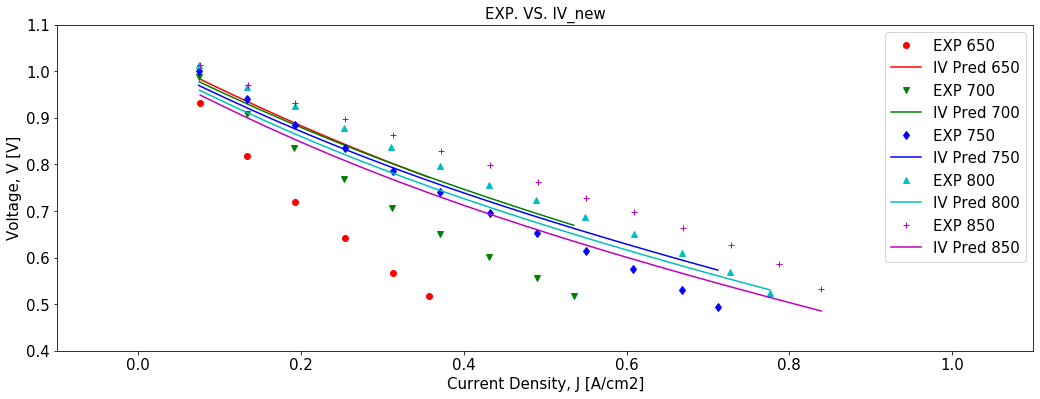

In [13]:
# comparison between JHM-2017 experimental data and   
#initilize and optimize
param_guess = (BV_alpha1, BV_prexp1, BV_Eact1, 0.0, 0.0, 0.28, 0.28)

# BV_alpha, BV_prexp, BV_Eact,V_loss=0.0, R_cont=0.0, 
# DsurfH2th1=0.1, DsurfH2th2=4.51e-5,
# Fkn=True, d0_am=0.28,d0_cm=0.28, th_e=10

Tlist = [650, 700, 750, 800, 850]
th_e = 10
param_fixed = [pO2air,pN2air,pH2,pH2O,pCO,pCO2,pCH4,pN2,pSys]

#objective_function_JM(param_guess, param_fixed, filename, IVmodel)
#obj_guess = objective_function_JM(param_guess, param_fixed, filenameJM, IVmodel)
bnds = ((0.3, 0.7), (0, None), (0, None), (None, 0), (0, None), (0.2, 2.0), (0.2, 2.0))
result = minimize(objective_function_JM, param_guess, args = (param_fixed), method = 'SLSQP', bounds = bnds)
print(result)

# plot and comparison
markerlist = ['o', 'v', 'd', '^', '+']
colorlist = ['r', 'g', 'b', 'c', 'm']
plt.figure(figsize=(17.5,6))

for i in range(len(Tlist)):
    oT = Tlist[i]+273.15
    fT = oT
    
    # plot exp data
    filename = './ExperimentalData/JM2017/'+str(Tlist[i])+'.csv'
    data = np.loadtxt(open(filename, "rb"), delimiter=",", skiprows=1)
    plt.plot(data[:,0], data[:,1], colorlist[i]+markerlist[i], label = 'EXP '+str(Tlist[i]))
    
    # initialize Jlist and Vlist
    Jlist=np.linspace(np.amin(data[:,0]), np.amax(data[:,0]), num=20)   #Current density, unit [A/cm2]
    Vlist = np.zeros(20)
    
    # plot pred data
    for j in range(20):
        Vlist[j], Voc, Ohmic, BV, Cath, Anode = IV_model.IV_new_2(oT,fT,Jlist[j],pO2air,pN2air,pH2,pH2O,pCO,pCO2,pCH4,pN2,pSys,
                                                       result.x[0],result.x[1],result.x[2],
                                                       result.x[3], result.x[4], 0.1, 4.51e-5,
                                                       True,result.x[5],result.x[6])
    plt.plot(Jlist, Vlist, colorlist[i]+'-', label = 'IV Pred '+str(Tlist[i]))

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(loc='upper right', fontsize=15)
plt.xlim(-0.1, 1.1)
plt.ylim(0.4, 1.1)
# ymin, ymax = plt.ylim()
# plt.ylim(ymin-(ymax-ymin)*0.0, ymax+(ymax-ymin)*0.0)
plt.xlabel('Current Density, J [A/cm2]', fontsize = 15)
plt.ylabel('Voltage, V [V]', fontsize = 15)
plt.title('EXP. VS. IV_new', fontsize = 15)

In [22]:
#comparison between Park-2020 experimental data (t8) and IV_new predicitons

#initilize and optimize
param_guess = (0.43236, 5639, 79616, 0.0, 0.0, 0.228, 0.228)
bnds = ((0.3, 0.6), (0, None), (0, None), (None, 0), (0, None), (0.2, 2.0), (0.2, 2.0)) ## bounds changed

# BV_alpha, BV_prexp, BV_Eact,V_loss=0.0, R_cont=0.0, 
# DsurfH2th1=0.1, DsurfH2th2=4.51e-5,
# Fkn=True, d0_am=0.28,d0_cm=0.28, th_e=10

Tlist = [600, 700, 800]
th_e = 8
param_fixed = [pO2air,pN2air,pH2,pH2O,pCO,pCO2,pCH4,pN2,pSys,th_e]

def objective_function_BP(param_guess, param_fixed):  
    filename = './ExperimentalData/BP2020/AllData_BP.csv'
    data = np.loadtxt(open(filename, "rb"), delimiter=",", skiprows=1)
    x = data[:,0]
    y_exp = data[:,1]
    Toper = data[:, 2]
    [pO2air,pN2air,pH2,pH2O,pCO,pCO2,pCH4,pN2,pSys,th_e] = param_fixed

    y_model = np.zeros(len(y_exp))
    for j in range(len(y_exp)):
        y_model[j], Voc, Ohmic, BV, Cath, Anode = IV_model.IV_new_3(Toper[j]+273.15,Toper[j]+273.15,x[j],
                                                           pO2air,pN2air,pH2,pH2O,pCO,pCO2,pCH4,pN2,pSys,
                                                           param_guess[0],param_guess[1],param_guess[2],
                                                           param_guess[3], param_guess[4], 
                                                           0.1, 4.51e-5, True, param_guess[5], param_guess[6],  th_e)
    rmse = mean_squared_error(y_exp, y_model, squared=False)
    return rmse

obj_guess = objective_function_BP(param_guess, param_fixed)
result = minimize(objective_function_BP, param_guess, args = (param_fixed), method = 'SLSQP', bounds = bnds)
print(result)

# plot and comparison
markerlist = ['o', 'v', 'd', '^', '+']
colorlist = ['r', 'g', 'b', 'c', 'm']

plt.figure(figsize=(17.5,6))

for i in range(len(Tlist)):
    oT = Tlist[i]+273.15
    fT = oT
    
    # plot exp data
    filename = './ExperimentalData/BP2020/t8/'+str(Tlist[i])+'.csv'
    data = np.loadtxt(open(filename, "rb"), delimiter=",", skiprows=1)
    plt.plot(data[:,0], data[:,1], colorlist[i]+markerlist[i], label = 'EXP '+str(Tlist[i]))
    
    # initialize Jlist and Vlist
    Jlist=np.linspace(np.amin(data[:,0]), np.amax(data[:,0]), num=20)   #Current density, unit [A/cm2]
    Vlist = np.zeros(20)
    
    # plot pred data
    for j in range(20):
        Vlist[j], Voc, Ohmic, BV, Cath, Anode = IV_model.IV_new_2(oT,fT,Jlist[j],pO2air,pN2air,pH2,pH2O,pCO,pCO2,pCH4,pN2,pSys, 
                                                         result.x[0],result.x[1],result.x[2], 
                                                         result.x[3], result.x[4], 
                                                         0.1, 4.51e-5, True, result.x[5], result.x[6],  th_e)
    plt.plot(Jlist, Vlist, colorlist[i]+'-', label = 'IV Pred '+str(Tlist[i]))

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(loc='upper right', fontsize=15)
ymin, ymax = plt.ylim()
plt.ylim(ymin-(ymax-ymin)*0.0, ymax+(ymax-ymin)*0.0)
plt.xlabel('Current Density, J [A/cm2]', fontsize = 15)
plt.ylabel('Voltage, V [V]', fontsize = 15)
plt.title('EXP. VS. IV_new', fontsize = 15)

TypeError: mean_squared_error() got an unexpected keyword argument 'squared'

In [23]:
import sklearn
print(sklearn.__version__)

0.19.1
